In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from textblob import TextBlob
%matplotlib inline

In [57]:
df = pd.read_csv('./funny_subreddit.csv', index_col=0)
df.head()

,date_created,is_video,number_of_comments,title,up_votes
0,2018-02-19 19:54:04,False,1,Restaurant be like,4
1,2018-02-19 19:52:21,True,0,Snacks for kiiiiiid... Ah!,0
2,2018-02-19 19:52:18,False,0,Checks out,1
3,2018-02-19 19:50:30,False,0,Don't drive drunk,1
4,2018-02-19 19:48:37,False,0,Difference between an Indian Cow and Buffalo.....,3


In [58]:
df.shape

(32789, 5)

In [59]:
polarity = []
subjectivity = []
for val in df['title']:
    blob = TextBlob(val)
    sentiment = blob.sentiment
    polarity.append(sentiment[0])
    subjectivity.append(sentiment[1])

In [60]:
df['polarity'] = polarity
df['subjectivity'] = subjectivity

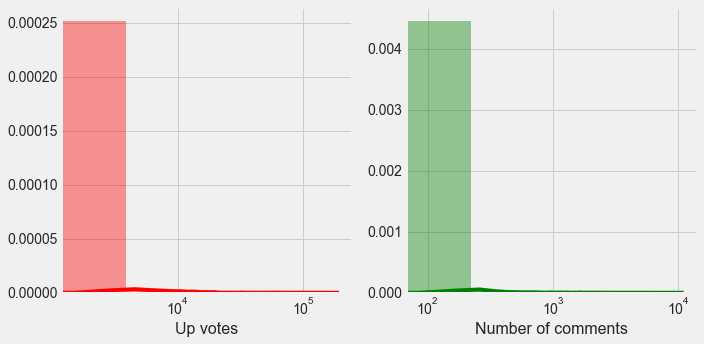

In [61]:
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(df['up_votes'],ax=axes[0], color='red')
sns.distplot(df['number_of_comments'], ax=axes[1], color='green')
axes[0].set_xlabel('Up votes', fontdict={'fontsize': 16})
axes[1].set_xlabel('Number of comments', fontdict={'fontsize': 16})
for ax in axes.flat:
    ax.semilogx()
    
plt.tight_layout()

In [62]:
#50th is 6, 80th is 38, 90th percentile is 183 up_votes, 95th 997 up_votes, 99th is 15170, max 192,674
df['up_votes'].quantile(q=.50)
df.loc[df['up_votes'] == 192674]['title'].values

array(['I took a few shots at Lake Louise today and Google offered me this panorama:'],
      dtype=object)

In [63]:
df['number_of_comments'].describe()
df.loc[df['number_of_comments'] == 11054]['title'].values

array(['Late post but I think we found out who my parents’ favorite child is.'],
      dtype=object)

Text(0,0.5,'Total up_votes')

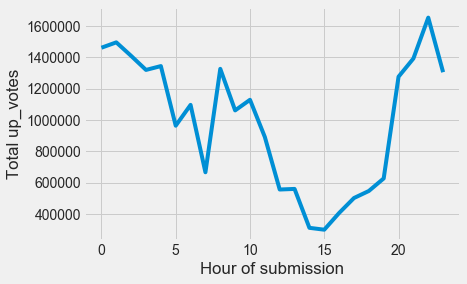

In [64]:
df['date_created'] = pd.to_datetime(df['date_created'])
df.groupby([df['date_created'].dt.hour])['up_votes'].sum().plot()
plt.xlabel('Hour of submission')
plt.ylabel('Total up_votes')

In [65]:
#Starting by looking at up votes, going to set it up by looking at the differences between
#top fifteen percent and those that received 0 up votes (4888 vs. 6910 observations). 
contrast = df[(df['up_votes'] > df['up_votes'].quantile(q=.85)) | (df['up_votes'] == 0)].reset_index(drop=True)

#creating 'viral' dummy
contrast['viral'] = (contrast['up_votes'] != 0).astype(int)
contrast.shape

(11798, 8)

Text(0.5,1,'Upvotes by day ')

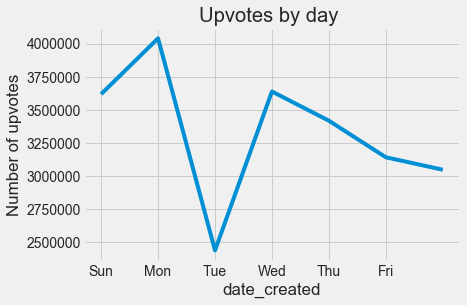

In [66]:
#total  up_votes by day
contrast.groupby([contrast['date_created'].dt.weekday])['up_votes'].sum().plot()
week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
plt.xticks(np.arange(0, 6, 1), week)
plt.ylabel('Number of upvotes')
plt.title('Upvotes by day ')

array([[1.        , 0.01884265],
       [0.01884265, 1.        ]])

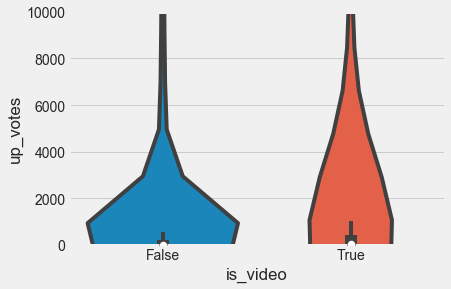

In [67]:
#is_video doesn't seem to be too relevant
fig, ax = plt.subplots()
ax.set_ylim(0, 10000)
sns.violinplot(y ='up_votes', x = 'is_video', data=contrast)
np.corrcoef(contrast['up_votes'], contrast['is_video'])

In [68]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
stop.add('would')
stop.add('like')
stop.add('year')
stop.add('one')
stop.add('day')
stop.add('get')
stop.add('u')
stop.add('v')
stop.add('say')
stop.add('let')
stop.add('made')
stop.add('got')



#'final' needs to be initialized if you want to run the function below for tfidf or
#countvectorizer. But for gensim, keep it deactivated. Also switch returns to finals...

def cleaner(title):
    """ This function accepts a string, tokenizes it, removes stopwords,
    lemmatizes them, and then return the words as a joined string"""
    tokenizer = RegexpTokenizer(r'\w+')
    no_chars = re.sub(r"[^a-zA-Z]", " ", title)
    titles = tokenizer.tokenize(no_chars.lower())
    lst = [word for word in titles if word not in stop and len(word) > 2 and word not in STOPWORDS]
    lst = [re.sub(r"[a]+[h]+", 'ahh', x) for x in lst]
    lst = [re.sub(r"[h]+[a]+", 'haha', x) for x in lst]
    lemons = [lemmatizer.lemmatize(word) for word in lst]
    #final = ' '.join(lemons)
    return lemons

In [69]:
#applying cleaner (now without reforming each title into a string)

contrast['title'] = contrast['title'].apply(cleaner)

In [70]:
#Creating gensim dictionary and corpus for topic analysis

dictionary = corpora.Dictionary(contrast['title'])

corpus = [dictionary.doc2bow(text) for text in contrast['title']]

speeches_topics = LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=10,
                           passes=8)

In [71]:
for i, topic in enumerate(speeches_topics.print_topics(2)):
    print('{} --- {}'.format(i, topic), '\n')

0 --- (7, '0.022*"look" + 0.015*"dad" + 0.014*"girl" + 0.014*"night" + 0.012*"lol" + 0.012*"paul" + 0.012*"logan" + 0.012*"thing" + 0.011*"need" + 0.010*"post"') 

1 --- (9, '0.025*"life" + 0.013*"car" + 0.010*"trying" + 0.010*"review" + 0.009*"thahanks" + 0.009*"amazon" + 0.008*"sent" + 0.008*"news" + 0.008*"prank" + 0.007*"phone"') 



In [72]:
contrast['title'] = contrast['title'].apply(lambda x: ' '.join(x))

In [73]:
#switch this to after test/train split
cv  = CountVectorizer(ngram_range=(1, 2))
X = contrast['title']
X = cv.fit_transform(X).toarray()
columns = cv.get_feature_names()

In [74]:
name_df = pd.DataFrame(X)
name_df.columns = columns

In [75]:
#Most common title words 
name_df.sum(axis=0).sort_values(ascending=False).head(20)

new       285
look      254
know      226
friend    219
time      215
guy       193
funny     172
tide      160
think     158
pod       155
dog       154
today     154
kid       154
cat       153
man       140
way       135
video     133
best      133
good      133
work      132
dtype: int64

In [76]:
X = pd.concat([pd.DataFrame(X), contrast['viral']], axis=1)
y = X['viral']
X = X.drop('viral', axis=1)

In [77]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.3)

In [78]:
transformer = TfidfTransformer()
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [79]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [80]:
preds = lr.predict(X_test)
print('accuracy: ', accuracy_score(y_test, preds))
print(classification_report(y_test, preds))
print('baseline: ', 4848/(4848+3410))

accuracy:  0.5888835069023977
             precision    recall  f1-score   support

          0       0.59      0.95      0.73      4810
          1       0.55      0.09      0.15      3448

avg / total       0.57      0.59      0.49      8258

baseline:  0.587067086461613


In [81]:
#now with TFIDF_vectorizer 

In [82]:
X_test, X_train, y_test, y_train = train_test_split(contrast['title'], contrast['viral'], test_size=0.3)

vectorizer = TfidfVectorizer(min_df=10, max_df=50, max_features=900)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [83]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
print(accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

0.5862194235892468
             precision    recall  f1-score   support

          0       0.60      0.88      0.71      4804
          1       0.52      0.17      0.26      3454

avg / total       0.56      0.59      0.52      8258



In [88]:
contrast.corr()

,is_video,number_of_comments,up_votes,polarity,subjectivity,viral
is_video,1.000000,0.033321,0.018843,-0.002284,-0.011338,0.054599
number_of_comments,0.033321,1.000000,0.831725,-0.003100,-0.000828,0.223857
up_votes,0.018843,0.831725,1.000000,-0.014103,-0.003804,0.232129
polarity,-0.002284,-0.003100,-0.014103,1.000000,0.189475,0.002375
subjectivity,-0.011338,-0.000828,-0.003804,0.189475,1.000000,-0.021590
viral,0.054599,0.223857,0.232129,0.002375,-0.021590,1.000000
